In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets, linear_model
import sys

import xgboost as xgb
import shap
from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

## 1 Read in Train/Test Sets

In [19]:
train = pd.read_csv('4klog2Norm.tsv', sep='\t',index_col=[0]).transpose()
# train = pd.read_csv('18kCPMNorm.tsv', sep='\t',index_col=[0]).transpose()
# intersect = [row for row in train.index if row not in t.index]
# train.drop(intersect, axis=0, inplace=True)
# train.index = np.array([int(x[-1]) for x in train.index])
# train.index
# plt.figure(figsize = (10, 7))
# sns.heatmap(train, annot=True)

In [20]:
# test = pd.read_csv('NormTest_name.tsv', sep='\t',index_col=[0])
# test.head()

In [5]:
# # check to make sure train and test sets are correct
# print('Number of matching rows:', len(np.intersect1d(train.index, test.index)))
# print('Number of matching cols:', len(np.intersect1d(train.columns, test.columns)))

In [6]:
# ## new dataframes for binary classification
idxs13 = (train.index == 1) + (train.index == 3)
train13 = train[idxs13]
idxs14 = (train.index == 1) + (train.index == 4)
train14 = train[idxs14]

# 2 Training XGBoost with Grid Search

In [22]:
# create the training matrix and label vector
X_train = train.values
y_train = np.array([int(x[-1]) for x in train.index])
y_train

array([2, 1, 3, 4, 1, 4, 1, 4, 2, 3, 2, 1, 2, 3, 4, 3, 2, 4, 1, 2, 2, 3,
       1, 1, 2, 3, 4, 3, 1, 4, 2, 2, 2, 3, 2, 1, 2, 3, 4, 1, 2, 1, 2, 3,
       1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 3, 1, 3, 4, 3, 3, 3,
       2, 4, 3, 2, 3, 3, 4, 3, 1, 3, 4, 2, 1, 3, 2, 2, 2, 1, 1, 3, 2, 3,
       1, 2, 1, 2, 2, 4, 3, 4, 3, 3, 2, 3, 4, 2, 1, 3, 1, 1, 2, 1, 3, 2,
       1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 3, 3, 3, 2, 3, 1, 3, 1, 1, 3, 3, 3,
       3, 3, 3, 1, 1, 4, 3, 4, 4, 1, 2, 3, 1, 1, 2, 2, 1, 3, 2, 3, 2, 1,
       2, 2, 2, 2, 4, 3, 2, 2, 4, 1, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3,
       1, 1, 3, 2, 1, 2, 3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 2, 1, 3, 2, 2, 2,
       1, 3, 3, 2, 4, 4, 1, 2, 4, 2, 1, 1, 3, 1, 1, 2, 1, 4, 1, 2, 2, 2,
       3, 2, 2, 3, 3, 2, 1, 3, 2, 2, 4, 1, 3, 1, 2, 4, 1, 1, 3, 4, 2, 1,
       2, 4, 2, 2, 1, 2, 2, 2, 1, 4, 2, 1, 4, 3, 2, 4, 2, 2, 2, 2, 3, 3,
       4, 1, 1, 2, 2, 2, 2, 1, 2, 4, 3, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 1,
       4, 2, 2, 3, 2, 2, 4, 2, 2, 1, 2, 4, 2, 2, 1,

In [7]:
# Binary classification groups
X_train13 = train13.values
y_train13 = train13.index
X_train14 = train14.values
y_train14 = train14.index

In [23]:
print("Before oversampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before oversampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before oversampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before oversampling, counts of label '4': {}".format(sum(y_train==4)))

Before oversampling, counts of label '1': 97
Before oversampling, counts of label '2': 160
Before oversampling, counts of label '3': 98
Before oversampling, counts of label '4': 52


In [8]:
# define initial grid search space
grid1 = {
    'max_depth' : range(1,6,2),
    'min_child_weight' : range(1,6,2),
    'reg_alpha' : [1e-5, 0.1, 1],
    'learning_rate' : [0.01, 0.1]
}

search1 = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1,
                                                  gamma=0, subsample=0.8,colsample_bytree=0.8, objective='multi:softmax',
                                                  n_jobs=4, scale_pos_weight=1, seed=27, num_classes=4, verbose=3),
                      param_grid = grid1, scoring='f1_micro', n_jobs=4, cv=10, iid=False)

In [9]:
starttime = time()
search1.fit(X_train, y_train)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')

C:\Users\Zach Moxley\Anaconda3\envs\dsci435\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Runtime: 231.81082890431085 minutes


AttributeError: 'GridSearchCV' object has no attribute 'best_score'

In [10]:
search1.scorer_, search1.best_params_, search1.best_score_

(make_scorer(f1_score, pos_label=None, average=micro),
 {'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 3,
  'reg_alpha': 0.1},
 0.49835365853658536)

In [7]:
best1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0, subsample=0.8,
                          colsample_bytree=0.8, objective='multi:softmax', n_jobs=4, scale_pos_weight=1, seed=27,
                          num_classes=4, verbose=3)

grid2 = {
    'subsample' : [0.6, 0.7, 0.8],
    'colsample_bytree' : [0.6, 0.7, 0.8]
}

search2 = GridSearchCV(estimator=best1, param_grid=grid2, scoring='f1_micro', n_jobs=4, cv=10, iid=False)

In [8]:
starttime = time()
search2.fit(X_train, y_train)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')
search2.scorer_, search2.best_params_, search2.best_score_

C:\Users\Zach Moxley\Anaconda3\envs\dsci435\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Runtime: 52.69484703540802 minutes


(make_scorer(f1_score, pos_label=None, average=micro),
 {'colsample_bytree': 0.8, 'subsample': 0.7},
 0.5184146341463415)

In [40]:
best2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0, subsample=0.7,
                          colsample_bytree=0.8, objective='multi:softmax', n_jobs=4, scale_pos_weight=1, seed=27,
                          num_classes=4, verbose=3)

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(best2, X_train, y_train, cv=StratifiedKFold(n_splits=10), verbose=10)
y_pred, y_train

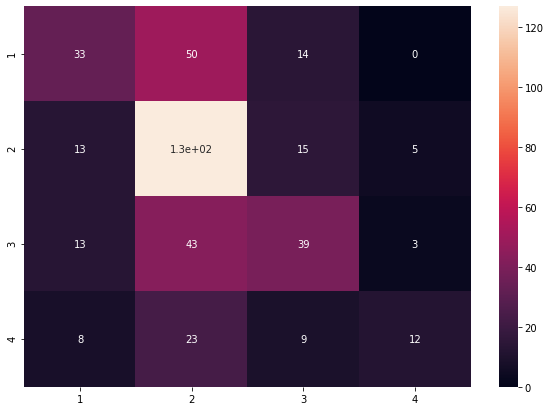

In [26]:
# confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_train, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True)

In [27]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', xgb.XGBClassifier())
    ])


param_dist = {'classification__learning_rate' : [0.1],
              'classification__n_estimators' : [100],
              'classification__subsample': [0.6, 0.7, 0.8],
              'classification__max_depth': [5],
              'classification__colsample_bytree': [0.6, 0.7, 0.8],
              'classification__min_child_weight': [3],
              'classification__n_jobs' : [4],
              'classification__objective' : ['multi:softmax'],
              'classification__num_classes' : [4],
              'classification__seed' : [27],
              'sampling__sampling_strategy': ['not majority', 'minority'],
              'sampling__random_state' : [7]
             }

best_param_dist = {'classification__learning_rate' : [0.1],
              'classification__n_estimators' : [100],
              'classification__subsample': [0.8],
              'classification__max_depth': [5],
              'classification__colsample_bytree': [0.6],
              'classification__min_child_weight': [3],
              'classification__n_jobs' : [4],
              'classification__objective' : ['multi:softmax'],
              'classification__num_classes' : [4],
              'classification__seed' : [27],
              'sampling__sampling_strategy': ['not majority'],
              'sampling__random_state' : [7]
             }

smote_search = GridSearchCV(model, best_param_dist, cv=10, n_jobs=4, scoring='f1_micro')
starttime = time()
smote_search.fit(X_train, y_train)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')
smote_search.scorer_, smote_search.best_params_, smote_search.best_score_

Runtime: 4.337066173553467 minutes


(make_scorer(f1_score, pos_label=None, average=micro),
 {'classification__colsample_bytree': 0.6,
  'classification__learning_rate': 0.1,
  'classification__max_depth': 5,
  'classification__min_child_weight': 3,
  'classification__n_estimators': 100,
  'classification__n_jobs': 4,
  'classification__num_classes': 4,
  'classification__objective': 'multi:softmax',
  'classification__seed': 27,
  'classification__subsample': 0.8,
  'sampling__random_state': 7,
  'sampling__sampling_strategy': 'not majority'},
 0.5159756097560976)

In [31]:
smotemodel = Pipeline([
        ('sampling', SMOTE(sampling_strategy='not majority')),
        ('classification', xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0,
                          subsample=0.8, colsample_bytree=0.6, objective='multi:softmax', n_jobs=4, seed=27,
                          num_classes=4, verbose=3))
])
smote_y_pred = cross_val_predict(smotemodel, X_train, y_train, cv=StratifiedKFold(n_splits=10), verbose=10, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  2.9min remaining:  1.2min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.6min finished


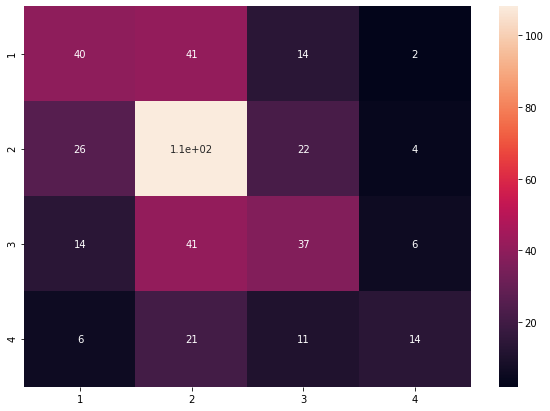

In [32]:
# confusion matrix
matrix = confusion_matrix(y_train, smote_y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True)

In [162]:
binary = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0, subsample=0.7,
                          colsample_bytree=0.8, objective='binary:logistic', scale_pos_weight=1, seed=27,
                          num_classes=4, verbose=3)
binsearch = GridSearchCV(binary, param_grid={'learning_rate' : [0.1]}, cv=StratifiedKFold(n_splits=10), n_jobs=4, scoring='f1')
starttime = time()
binsearch.fit(X_train13, y_train13)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')
binsearch.best_score_

0.659599773478492

In [ ]:
binsearch2 = GridSearchCV(binary, param_grid={'learning_rate' : [0.1]}, cv=StratifiedKFold(n_splits=10), n_jobs=4, scoring='f1')
starttime = time()
binsearch2.fit(X_train14, y_train14)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')
binsearch2.best_score_

# 3 XGB parameters and gene ranking

<function matplotlib.pyplot.show(*args, **kw)>

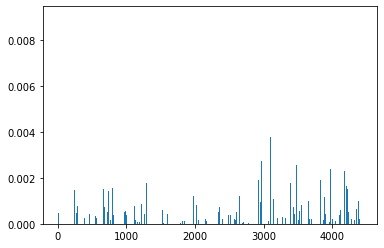

In [33]:
from matplotlib import pyplot
f = smote_search.best_estimator_['classification'].feature_importances_
pyplot.bar(range(len(f)), f)
pyplot.title('')
pyplot.show

In [34]:
# rank features by importance
rankings = np.flip(np.argsort(f))
f[rankings]

array([0.00902909, 0.00511358, 0.00468258, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

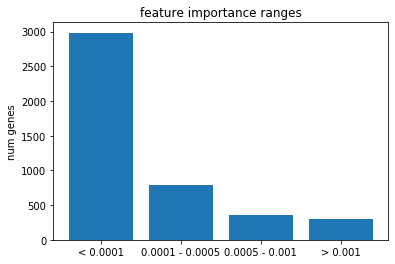

In [35]:
# feature importance histogram
hist = {'< 0.0001' : 0,
        '0.0001 - 0.0005' : 0,
        '0.0005 - 0.001' : 0,
        '> 0.001' : 0
       }
for rank in rankings:
    if f[rank] < 0.0001:
        hist['< 0.0001'] += 1
    elif f[rank] < 0.0005:
        hist['0.0001 - 0.0005'] += 1
    elif f[rank] < 0.001:
        hist['0.0005 - 0.001'] += 1
    else:
        hist['> 0.001'] += 1

pyplot.bar(hist.keys(), hist.values(), width=0.8)
pyplot.title('feature importance ranges')
pyplot.ylabel('num genes')
pyplot.show()

In [36]:
train.columns[rankings]

Index(['CCER1', 'NGB', 'AL356806.3', 'PAPLN', 'DPCR1', 'GPR32P1', 'AC016700.2',
       'CFB', 'C1S', 'RAPSN',
       ...
       'BCRP1', 'RP11-390P2.4', 'BUB3', 'CCSAP', 'ENAH', 'DUXAP9', 'HSPA7',
       'ZNRF2P2', 'TOMM70', 'ZNF641'],
      dtype='object', name='external_gene_name', length=4438)

In [37]:
bestgenes = [x for x in rankings if f[x] > 0.001]
train.columns[bestgenes]

Index(['CCER1', 'NGB', 'AL356806.3', 'PAPLN', 'DPCR1', 'GPR32P1', 'AC016700.2',
       'CFB', 'C1S', 'RAPSN',
       ...
       'SEPHS1P4', 'MBOAT1', 'RP3-355L5.4', 'RP11-832A4.7', 'CYP4V2', 'C1QB',
       'RP11-165M1.1', 'COL4A6', 'SKIDA1', 'HSPB1P2'],
      dtype='object', name='external_gene_name', length=302)

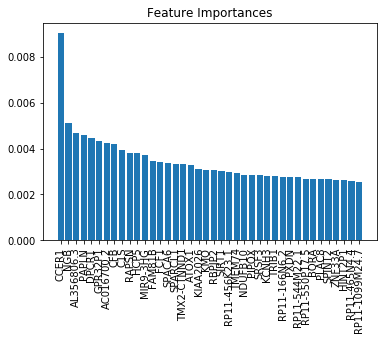

In [38]:
pyplot.bar(train.columns[bestgenes][:40], f[bestgenes][:40], orientation='vertical')
pyplot.xticks(train.columns[bestgenes][:40], rotation=90)
pyplot.title('Feature Importances')
pyplot.show()

In [41]:
best2.fit(X_train, y_train)
f2 = best2.feature_importances_

In [45]:
rankings = np.flip(np.argsort(f2))
bestgenes2 = [x for x in rankings if f2[x] > 0.001]

In [46]:
train.columns[bestgenes2]

Index(['OSTC', 'COX4I1', 'BLOC1S5', 'TRIM6', 'FMO4', 'OR14I1', 'CD69', 'APOOL',
       'KAT2B', 'JAML',
       ...
       'CAPNS2', 'RP4-663N10.1', 'LDHAL6A', 'RP11-863K10.7', 'B3GALT5',
       'RP11-313P18.2', 'P2RX5', 'RP11-242D8.3', 'TRAF3IP3', 'RP11-323F24.4'],
      dtype='object', name='external_gene_name', length=313)

In [47]:
# create the feature list for each model
def genes_to_csv(feature_list, model_name):
    ranking = np.flip(np.argsort(feature_list))
    gene_dict = {'score' : feature_list[ranking], 
                 'gene_name' : train.columns[ranking]}
    genedf = pd.DataFrame(data=gene_dict)
    genedf.to_csv(model_name + '_genelist.csv', index=False)

In [48]:
genes_to_csv(f, 'xgbsmote')

In [49]:
genes_to_csv(f2, 'xgb')